# Homework 2 - balancing, transformations, and dimensionality reduction (deadline 17. 12. 2023, 23:59)

In short, the main task is to play with balancing, binning, transformations, and dimensionality reduction to obtain the best results for the binary classification task.
  
> The instructions are not given in detail: It is up to you to come up with ideas on how to fulfill the particular tasks as best you can!

However, we **strongly recommend and require** the following:
* Follow the assignment step by step. Number each step.
* Properly comment on all your steps. Use Markdown cells and visualizations. Comments are evaluated for 2 points of the total, together with the final presentation of the solution. However, it is not desirable to write novels! 
* This task is timewise and computationally intensive. Do not leave it to the last minute.
* Most steps contain the number of features that should be treated. You can preprocess more features. However, it does not mean the teacher will give you more points. Focus on quality, not quantity.
* Hand in a notebook that has already been run (i.e., do not delete outputs before handing in).

## What are you supposed to do:

  1. Download the dataset [here](https://www.dropbox.com/s/aq08ytozfplb97b/data.csv?dl=0). Split the dataset into a train, validation, and test set and **use these parts correctly (!)** in the following steps.
  1. Choose at least one classification algorithm whose performance is to be improved in the following steps.
  1. Use at least two binning methods (on features of your choice, with your choice of parameters) and comment on their effects on classification performance. _I.e., one kind of classifier trained for each binning and a comparison of the effect of binning methods against each other._ _(4 points, depends on creativity)_ 
  1. Use at least two data balancing techniques on the correct part of the dataset and comment on its effects on classification performance. Focus on the comparison of methods between each other. _I.e., one type of classifier trained for each balancing and a comparison of the effect of balancing methods against each other._ **Just copied code from tutorial four will not be accepted.** _(6 points, depends on creativity)_
  1. Transform the features appropriately and prepare new ones (i.e., feature engineering) - focus on the increase in the model's performance (possibly in combination with further steps). _(5 points, depends on creativity)_ 
  1. Try to find some suitable subset of features - use at least two feature selection methods. Evaluate your choice on the validation set and discuss the influence. Do not use PCA (principal component analysis) in this step. Manual selection will not be accepted. _(4 points, depends on creativity)_
  1. Use PCA to reduce the dimensionality. Discuss the influence of the number of principal components. _(4 points)_
  1. Try to find the best combination of the previous steps and run final classification tests on the correct part of the dataset - first for the original data, second for the best-found combination of the previous preprocessing steps. Compare the results and discuss (give a comment, use graphs, and so on). _(5 points)_

All your steps, choices, and the following code **must be commented on!** For text comments (discussion, etc., not code comments), use **Markdown cells**. Comments are evaluated for _2 points_ together with the final presentation of the solution.

**If you do all this properly, you will obtain 30 points.**

### FAQ

* Select the appropriate metric to evaluate the classification results.
* In steps 2 and 3, you are comparing methods against each other, not their effect on unadjusted data. However, you can comment on that, too.
* You choose the subset of features only in step 2 because of the binning methods. In the other steps, you work with the whole dataset.

## Comments

  * Please follow the technical instructions from https://courses.fit.cvut.cz/NI-PDD/homeworks/index.html.
  * Methods that are more complex and were not shown during the tutorials are considered more creative and should be described in detail.
  * English is not compulsory.

  
## Data description

* The dataset can be downloaded [here](https://www.dropbox.com/s/aq08ytozfplb97b/data.csv?dl=0).
* The data are devoted to the binary classification task. The aim is to predict the probability that a driver will initiate an auto insurance claim next year.
* The target feature is called 'y' and signifies whether or not a claim was filed for that policyholder.
* To fulfill the task, one does not need to know the meaning of predictors.
* Predictors that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix _bin_ to indicate binary features and the postfix _cat_ to indicate categorical features. Features without these designations are either continuous or ordinal. Values of -1 indicate that the feature was missing from the observation.
* While using [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), control the shuffling of data by random_state parameter. Do not use shuffle=False, probably never (can cause systematic error).

In [1]:
### here comes your code

import numpy as np
import pandas as pd

from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import ExtraTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import mean_squared_log_error, make_scorer, mean_squared_error, confusion_matrix, accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import itertools
import seaborn as sns

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import ADASYN

from catboost import CatBoostClassifier

# 1. Download dataset and split into train and test part

In [2]:
df = pd.read_csv('data.csv')

In [3]:
# We have dataset without nulls and nans
print(df.isna().sum().sum())
print(df.isnull().sum().sum())

0
0


In [4]:
# Split dataset onto train and test part
X = df.drop('y', axis=1)
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=42)
print(X_train.shape, X_test.shape)

(476169, 57) (119043, 57)


# 2 Choose at least one classification algorithm whose performance is to be improved in the following steps.

I decided to choose Decision Tree classifier because it has lower accuracy and f1-score than other classification algorithms and one of the fastest. I also tried DecisionTreeClassifier, RandomForestClassifier, AdaBoostClassifier.

In [5]:
clf = DecisionTreeClassifier()
y_pred = clf.fit(X_train, y_train).predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)

print(cnf_matrix)
accuracy_score_without_bin = accuracy_score(y_test, y_pred)
f1_score_without_bin = f1_score(y_test, y_pred)
print('Accuracy: ', accuracy_score_without_bin,'\nF1-score: ', f1_score_without_bin)

[[108991   5634]
 [  4122    296]]
Accuracy:  0.9180464202011038 
F1-score:  0.0572091225357557


In [6]:
# helper function to plot confusion matrix
# code taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = (cm.max() + cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

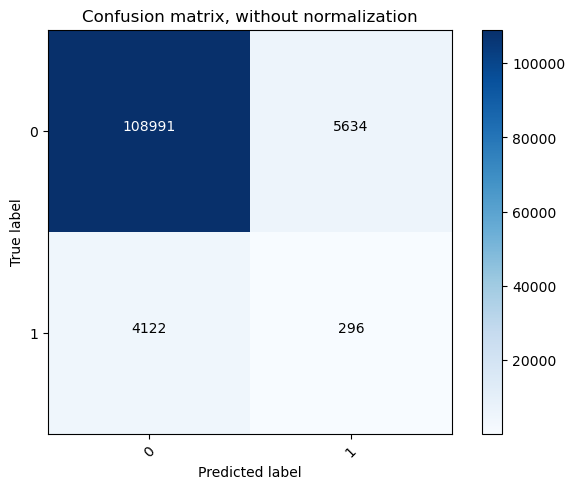

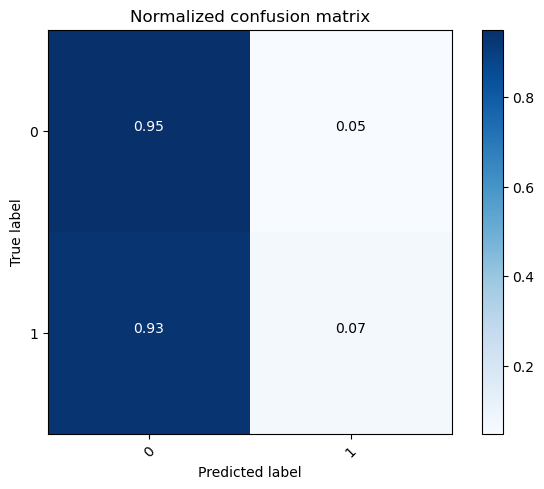

In [7]:
# Confusion matrix for decision tree
np.set_printoptions(precision=2)
class_names = [0,1] # for printing purposes only

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

Plot histograms below will show distribution of features we have. Here we can see some almost constant features or continues variables. 

array([[<Axes: title={'center': 'y'}>,
        <Axes: title={'center': 'xind_01'}>,
        <Axes: title={'center': 'xind_02_cat'}>,
        <Axes: title={'center': 'xind_03'}>,
        <Axes: title={'center': 'xind_04_cat'}>,
        <Axes: title={'center': 'xind_05_cat'}>,
        <Axes: title={'center': 'xind_06_bin'}>,
        <Axes: title={'center': 'xind_07_bin'}>],
       [<Axes: title={'center': 'xind_08_bin'}>,
        <Axes: title={'center': 'xind_09_bin'}>,
        <Axes: title={'center': 'xind_10_bin'}>,
        <Axes: title={'center': 'xind_11_bin'}>,
        <Axes: title={'center': 'xind_12_bin'}>,
        <Axes: title={'center': 'xind_13_bin'}>,
        <Axes: title={'center': 'xind_14'}>,
        <Axes: title={'center': 'xind_15'}>],
       [<Axes: title={'center': 'xind_16_bin'}>,
        <Axes: title={'center': 'xind_17_bin'}>,
        <Axes: title={'center': 'xind_18_bin'}>,
        <Axes: title={'center': 'xreg_01'}>,
        <Axes: title={'center': 'xreg_02'}>,
   

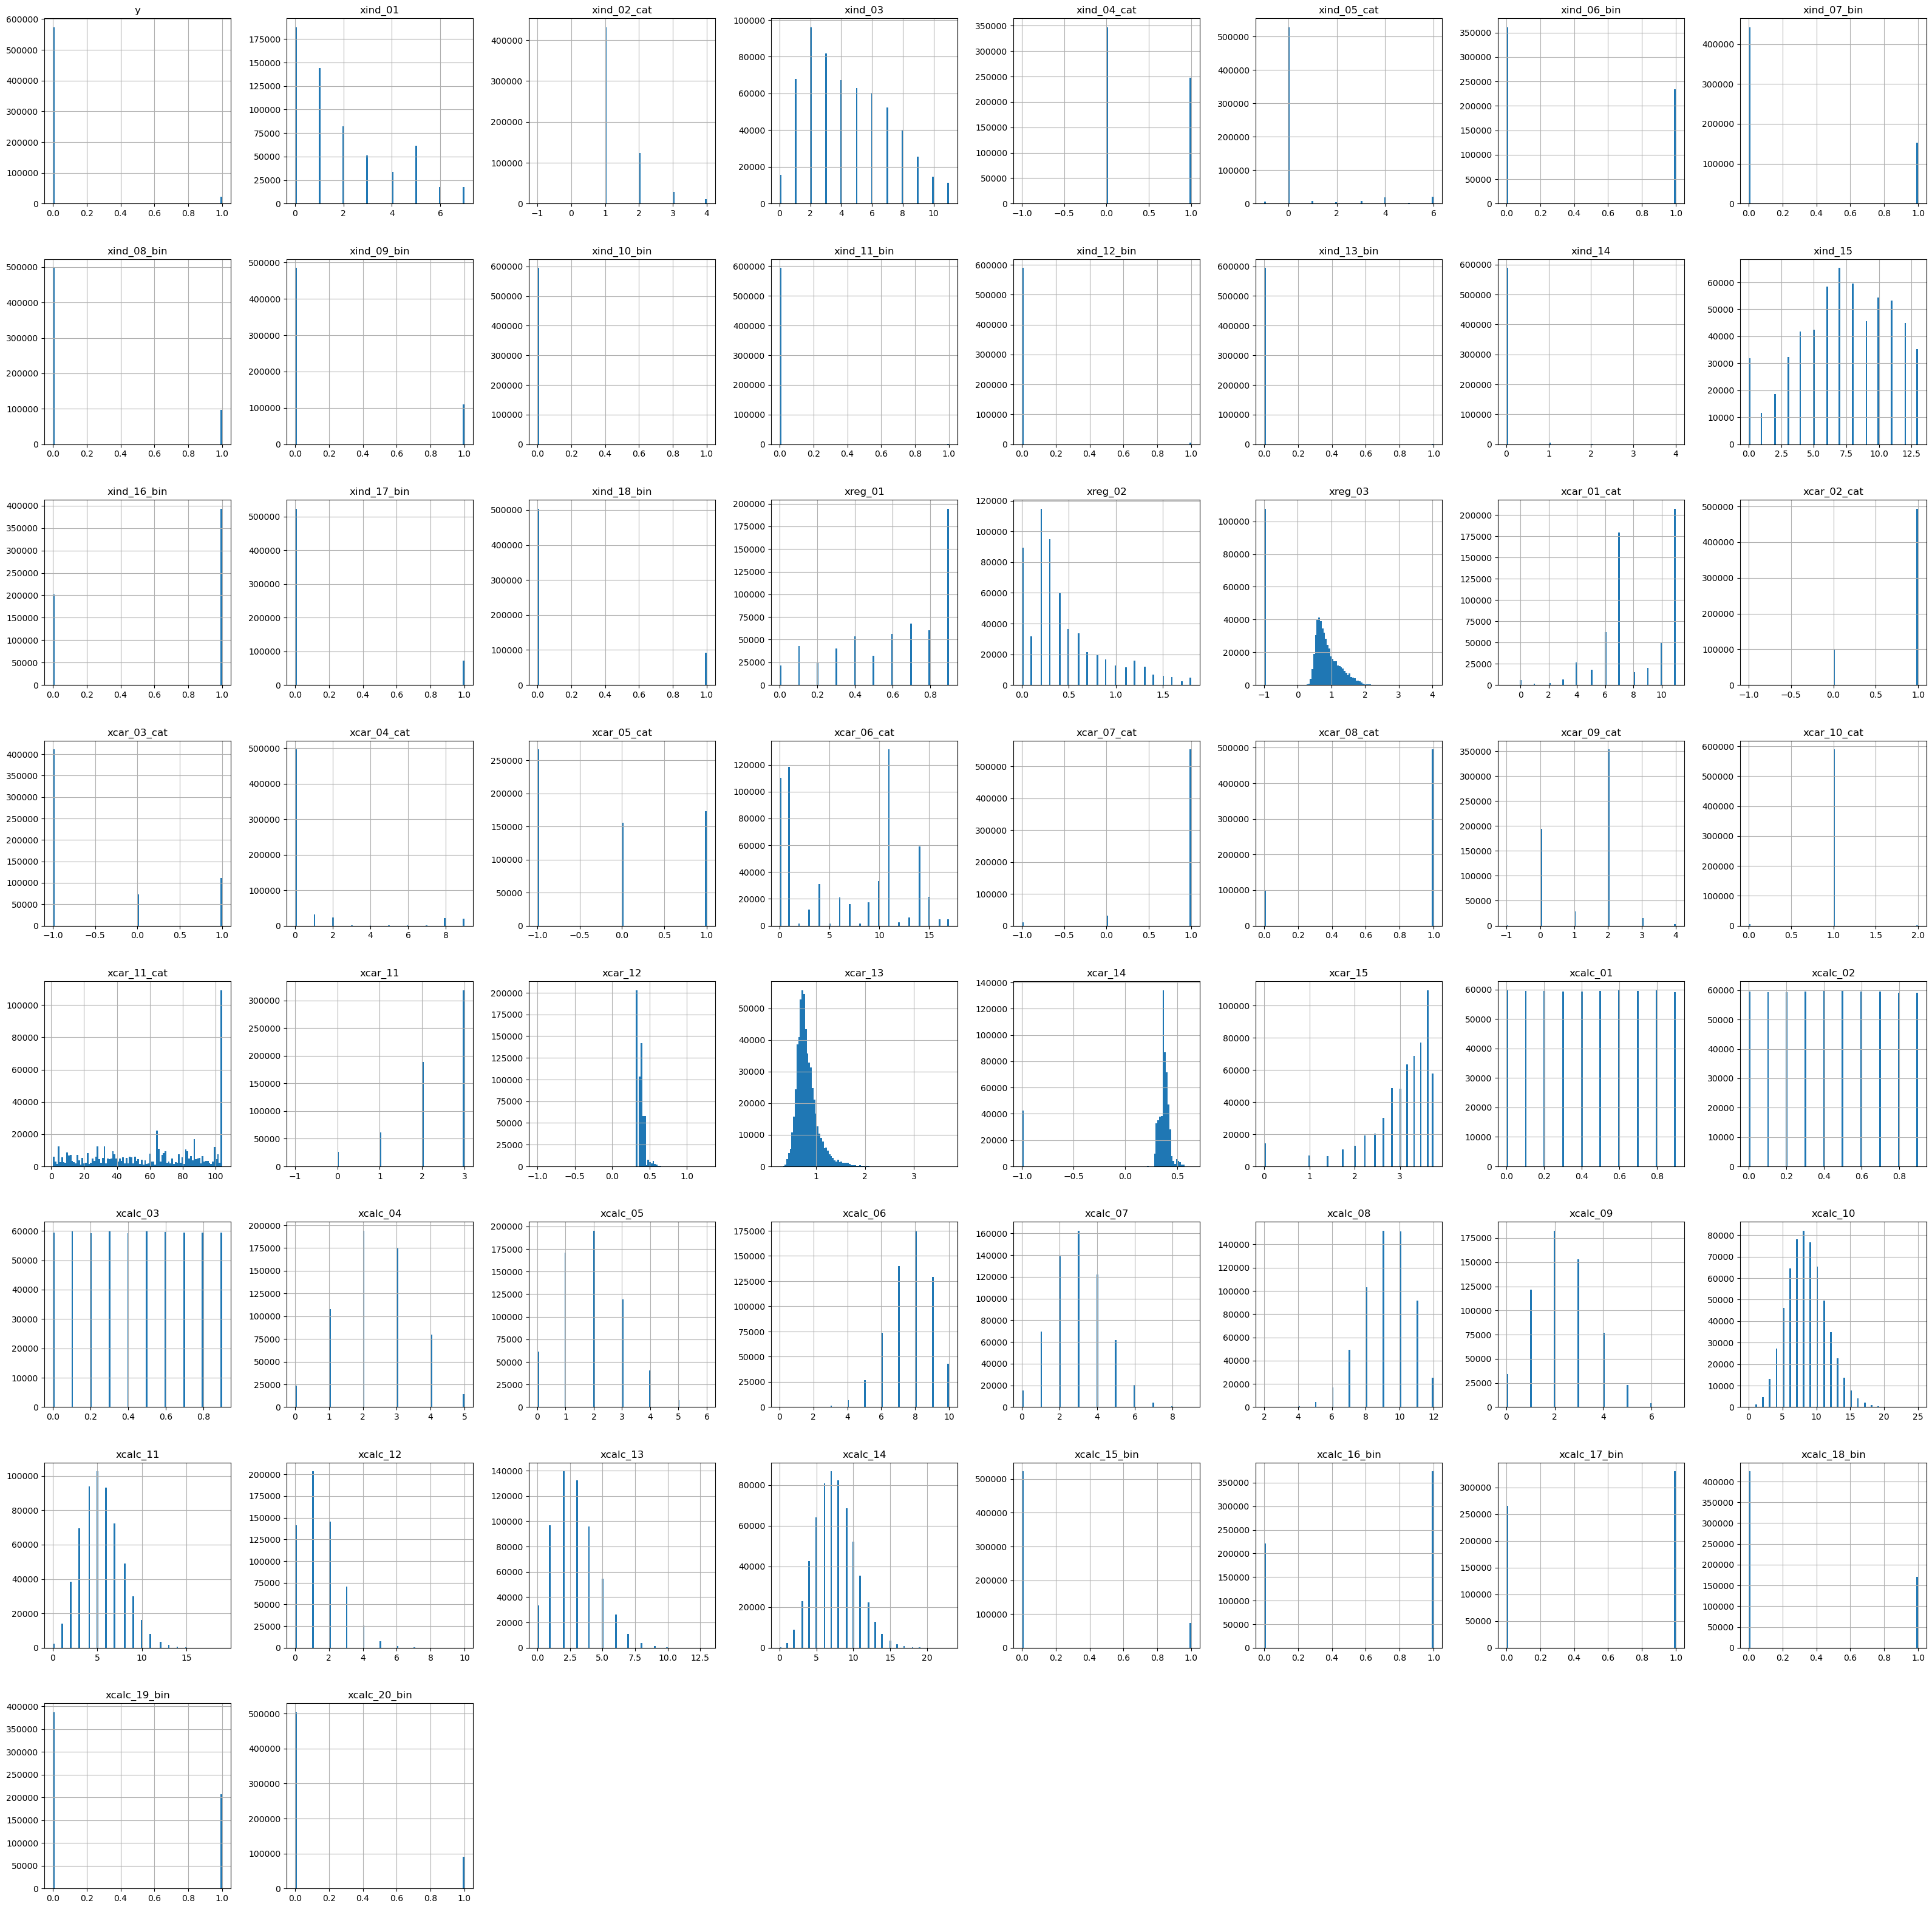

In [8]:
# plot histograms for all variables to see their distribution.
df[[x for x in df.columns]].hist(figsize=(40,40), bins=100)

# 3 Use at least two binning methods (on features of your choice, with your choice of parameters) and comment on their effects on classification performance.

I decided to choose xreg_03 and xcar_13 features because they have continuous data which is good for applying binning methods.

In [9]:
df_copy = df.copy()

In [10]:
# Equal depth binning 
# Divide columns into bins with the same bins' size
col_bin = ['xreg_03', 'xcar_13']
for col in col_bin:
    df_copy[col] = pd.qcut(df_copy[col], q=4).cat.codes

/var/folders/m9/2cd05q1j4fl8srwg4j3207qh0000gn/T/ipykernel_54992/2235430206.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_copy['xreg_03'], hist=True, kde=False)


<Axes: xlabel='xreg_03'>

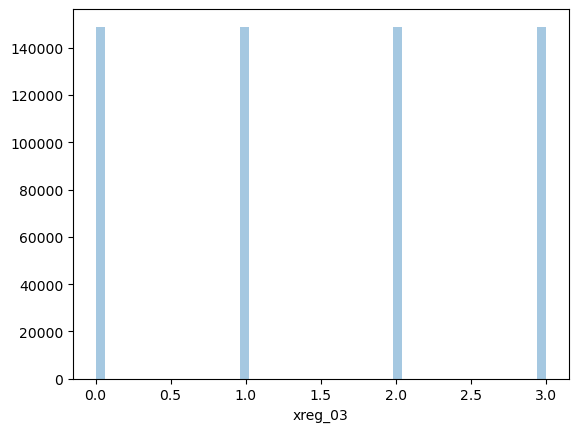

In [11]:
sns.distplot(df_copy['xreg_03'], hist=True, kde=False)

/var/folders/m9/2cd05q1j4fl8srwg4j3207qh0000gn/T/ipykernel_54992/3793729195.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_copy['xcar_13'], hist=True, kde=False)


<Axes: xlabel='xcar_13'>

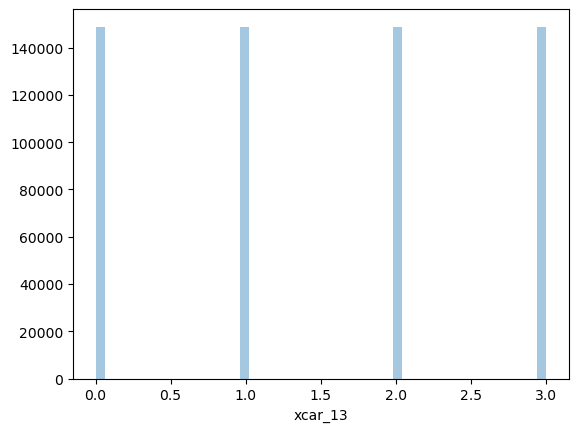

In [12]:
sns.distplot(df_copy['xcar_13'], hist=True, kde=False)

In [13]:
# Apply decision tree classifier after equal depth binning
X, y = df_copy.drop('y', axis=1), df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=True, random_state=42)
clf = DecisionTreeClassifier()
y_pred = clf.fit(X_train, y_train).predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)

print(cnf_matrix)
accuracy_score_depth_bin = accuracy_score(y_test, y_pred)
f1_score_depth_bin = f1_score(y_test, y_pred)
print('Accuracy: ', accuracy_score_depth_bin,'\nF1-score: ', f1_score_depth_bin)

[[108910   5715]
 [  4109    309]]
Accuracy:  0.9174751980376838 
F1-score:  0.05918406435548746


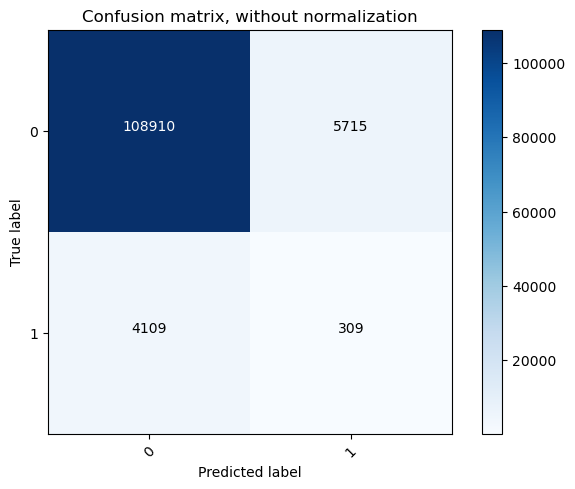

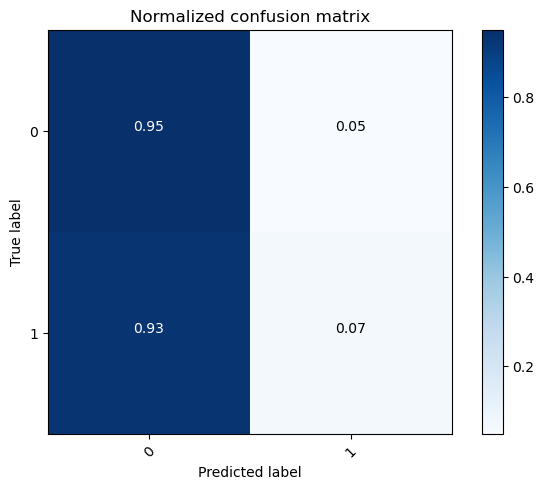

In [14]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

In [15]:
df_copy = df.copy()

In [16]:
# Equal width binning
# Divide columns into bins with the same interval 
bins_names = [1, 2, 3, 4, 5]
for col in col_bin:
    df_copy[col] = pd.cut(df_copy[col], 5, labels=bins_names, retbins=True)[0]

/var/folders/m9/2cd05q1j4fl8srwg4j3207qh0000gn/T/ipykernel_54992/2235430206.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_copy['xreg_03'], hist=True, kde=False)


<Axes: xlabel='xreg_03'>

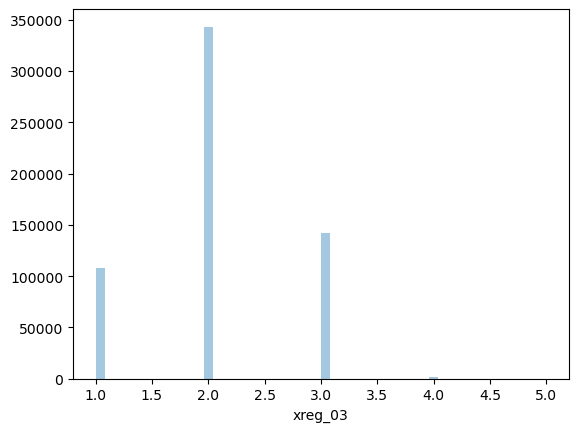

In [17]:
sns.distplot(df_copy['xreg_03'], hist=True, kde=False)

/var/folders/m9/2cd05q1j4fl8srwg4j3207qh0000gn/T/ipykernel_54992/3793729195.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_copy['xcar_13'], hist=True, kde=False)


<Axes: xlabel='xcar_13'>

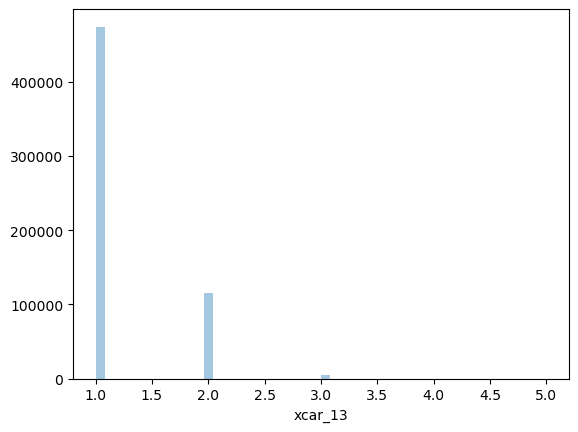

In [18]:
sns.distplot(df_copy['xcar_13'], hist=True, kde=False)

In [19]:
# Apply decision tree classifier after equal width binning
X, y = df_copy.drop('y', axis=1), df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=True, random_state=42)
clf = DecisionTreeClassifier()
y_pred = clf.fit(X_train, y_train).predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)

print(cnf_matrix)
accuracy_score_width_bin = accuracy_score(y_test, y_pred)
f1_score_width_bin = f1_score(y_test, y_pred)
print('Accuracy: ', accuracy_score_width_bin,'\nF1-score: ', f1_score_width_bin)

[[109008   5617]
 [  4165    253]]
Accuracy:  0.917828011726855 
F1-score:  0.04918351477449456


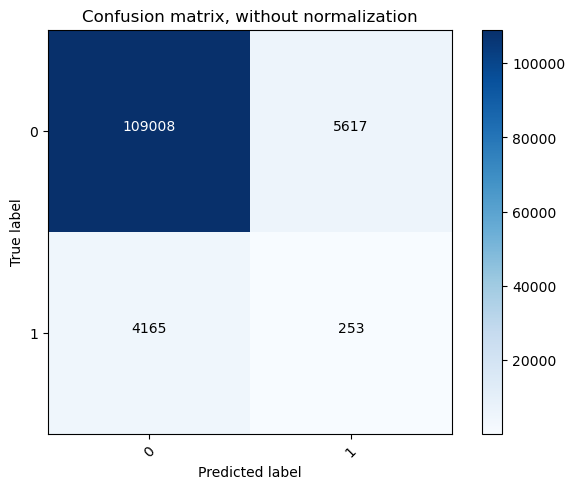

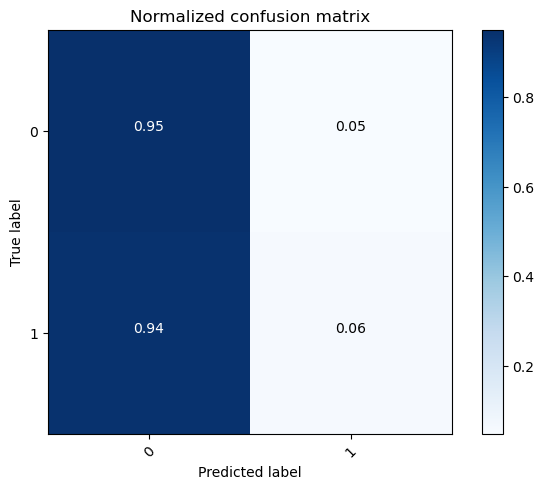

In [20]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

In [21]:
print('Without binning')
print('Accuracy score:', accuracy_score_without_bin)
print('F1 score:', f1_score_without_bin)
print('Depth binning')
print('Accuracy score:', accuracy_score_depth_bin)
print('F1 score:', f1_score_depth_bin)
print('Width binning')
print('Accuracy score:', accuracy_score_width_bin)
print('F1 score:', f1_score_width_bin)

Without binning
Accuracy score: 0.9180464202011038
F1 score: 0.0572091225357557
Depth binning
Accuracy score: 0.9174751980376838
F1 score: 0.05918406435548746
Width binning
Accuracy score: 0.917828011726855
F1 score: 0.04918351477449456


After applying equal width and equal depth binning we can see that accuracy is the same for all cases but f1 score is lower for width binning.

# 4 Use at least two data balancing techniques on the correct part of the dataset and comment on its effects on classification performance

The first method I used is ADASYN. It is working for imbalanced data and based on oversampling minority class. ADASYN analyzed minority points neighbours and based on them generate new examples.  

In [22]:
X, y = df.drop('y', axis=1), df['y']

In [23]:
# Proof of imbanaced dataset
print('{:.2f}% of instances are labeled with class 0.\n{:.2f}% of instances are labeled with class 1.'.format(np.sum(y == 0) / len(y) * 100, np.sum(y == 1) / len(y) * 100))

96.36% of instances are labeled with class 0.
3.64% of instances are labeled with class 1.


In [24]:
# Balance dataset with ADASYN
ada = ADASYN(random_state=42)
X_ada, y_ada = ada.fit_resample(X_train, y_train)
print('{:.2f}% of instances are labeled with class 0.\n{:.2f}% of instances are labeled with class 1.'.format(np.sum(y_ada == 0) / len(y_ada) * 100, np.sum(y_ada == 1) / len(y_ada) * 100))

49.77% of instances are labeled with class 0.
50.23% of instances are labeled with class 1.


In [25]:
# Apply decision tree classifier to test new approach
clf = DecisionTreeClassifier()
y_pred = clf.fit(X_ada, y_ada).predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)

print(cnf_matrix)
accuracy_score_ada = accuracy_score(y_test, y_pred)
f1_score_ada = f1_score(y_test, y_pred)
print('Accuracy: ', accuracy_score_ada,'\nF1-score: ', f1_score_ada)

[[114624      1]
 [  4416      2]]
Accuracy:  0.9628957603555018 
F1-score:  0.0009047726758651889


The second method I used is undersampled method called Near Miss. It is also based on selecting k-nearest neighbours. I will use version 3 of this algorightm. For each minority point it selects its k-nearest neighbours then the majority class instance will be selected for thich the average distance to the nearest neighbours is the largest.

In [26]:
near_miss = NearMiss(version=3)
X_near_miss, y_near_miss = near_miss.fit_resample(X_train, y_train)
print('{:.2f}% of instances are labeled with class 0.\n{:.2f}% of instances are labeled with class 1.'.format(np.sum(y_near_miss == 0) / len(y_near_miss) * 100, np.sum(y_near_miss == 1) / len(y_near_miss) * 100))

50.00% of instances are labeled with class 0.
50.00% of instances are labeled with class 1.


In [27]:
# Apply decision tree classifier to test near miss approach
clf = DecisionTreeClassifier()
y_pred = clf.fit(X_near_miss, y_near_miss).predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)

print(cnf_matrix)
accuracy_score_near_miss = accuracy_score(y_test, y_pred)
f1_score_near_miss = f1_score(y_test, y_pred)
print('Accuracy: ', accuracy_score_near_miss,'\nF1-score: ', f1_score_near_miss)

[[49229 65396]
 [ 1948  2470]]
Accuracy:  0.4342884503918752 
F1-score:  0.06834154169664103


After applying both methods we can make a decision that it is better to make oversampling rather than undersampling. Because undersampling decrease number of examples to train which leads worst accuracy results. 

# 5. and 6. Transform and select features

The Decision Tree classifier in its algorithm uses Atribute Selection Measure(ASM) to select the best attributes. The goal of ASM is to identify the attribute that will create the most homogeneous subsets of data after the split, thereby maximizing the information gain. So I decided to select the most important attributes by calculating the number of non-unique values in each column. 

In [28]:
count_asm_dict = {}
for column in df.columns:
    count_asm = df[column].nunique()
    count_asm_dict[column] = count_asm
    
sorted_asm_dict = dict(sorted(count_asm_dict.items(), key=lambda item: item[1], reverse=True))
columns = list(sorted_asm_dict.keys())[0:5]
columns.append('y')

In [29]:
df_new = df[columns]
len(df_new.columns)

6

In [30]:
df_new.head()

xcar_13   xreg_03   xcar_14   xcar_12  xcar_11_cat  y
0  0.748359  0.602599 -1.000000  0.316228           80  0
1  0.738675  0.511126  0.401373  0.400000           95  0
2  0.820514 -1.000000  0.331361  0.400000           42  0
3  0.633158  0.463006  0.368782  0.316228           99  0
4  1.016445  0.685109  0.425676  0.400000          104  0

In [31]:
df_new = df[columns]
X = df_new.drop('y', axis=1)
y = df_new['y']
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=42)
clf = DecisionTreeClassifier()
y_pred = clf.fit(X_train, y_train).predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)

print(cnf_matrix)
accuracy_score_test = accuracy_score(y_test, y_pred)
f1_score_test = f1_score(y_test, y_pred)
print('Accuracy: ', accuracy_score_test,'\nF1-score: ', f1_score_test)

(595212, 5) (595212,)
[[110163   4462]
 [  4204    214]]
Accuracy:  0.9272027754676881 
F1-score:  0.047063998240598204


As we can see this aproach has slightly better accuracy then all methods we used before. It is difficult to find the reason why it is happend because this approach is also used within decision tree algorithm itself. But it will increase speed of the decision tree algorithm.

Then I tried to standardize dataset because for example x_car_11_cat has really high variance compared with other features.

In [32]:
# Standardisation 
X, y = df_copy.drop('y', axis=1), df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=True, random_state=42)
scaler = StandardScaler()

scaler.fit(X)
# Standardize the selected numerical columns
X_train_standard = scaler.transform(X_train)
X_test_standard = scaler.transform(X_test)

In [33]:
clf = DecisionTreeClassifier()
y_pred = clf.fit(X_train_standard, y_train).predict(X_test_standard)
cnf_matrix = confusion_matrix(y_test, y_pred)

print(cnf_matrix)
accuracy_score_test = accuracy_score(y_test, y_pred)
f1_score_test = f1_score(y_test, y_pred)
print('Accuracy: ', accuracy_score_test,'\nF1-score: ', f1_score_test)

[[108938   5687]
 [  4161    257]]
Accuracy:  0.9172735902153003 
F1-score:  0.04960432348967381


So nothing significantly changed after standardization

Also for feature selection I used Recursive Feature Elimination(RFE) algorithm which is based on ranking each feature using RFE algorithm and then remove the least important feature until desired number of features are reached. As we can see below accuracy and f1-score aren't changed so much. 

In [34]:
X = df.drop('y', axis=1)
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=42)

clf = DecisionTreeClassifier()
rfe = RFE(clf, n_features_to_select=5)
rfe.fit(X_train, y_train)
y_pred = rfe.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pred)

print(cnf_matrix)
accuracy_score_test = accuracy_score(y_test, y_pred)
f1_score_test = f1_score(y_test, y_pred)
print('Accuracy: ', accuracy_score_test,'\nF1-score: ', f1_score_test)

[[109415   5210]
 [  4155    263]]
Accuracy:  0.9213309476407685 
F1-score:  0.05317965827519967


Also I tried to use Pearson and Spearman correlation metrics to find most important features based on their correlation with y. But as we will se below all fetures has more or less the same effect to the y variable.  

In [35]:
low_variance_columns = df.columns[df.var() < 0.01]
low_variance_columns
df_filtered = df.drop(columns=low_variance_columns)

In [36]:
corrP = df.drop(low_variance_columns, axis = 1, errors = 'ignore').corr(method='pearson')
corrS = df.drop(low_variance_columns, axis = 1, errors = 'ignore').corr(method='spearman')

In [37]:
# Pearson top 10 with target
corrP_cols = corrP.y.abs().nlargest(10).index # get the index and then plot the real values
display(corrP.y.loc[corrP_cols])
# Spearman top 10 with target
corrS_cols = corrS.y.abs().nlargest(10).index
display(corrS.y.loc[corrS_cols])

y              1.000000
xcar_13        0.053899
xind_17_bin    0.037053
xcar_07_cat   -0.036395
xreg_02        0.034800
xind_07_bin    0.034218
xind_06_bin   -0.034017
xcar_04_cat    0.032900
xcar_03_cat    0.032401
xcar_02_cat   -0.031534
Name: y, dtype: float64

y              1.000000
xcar_13        0.049692
xreg_03        0.037385
xind_17_bin    0.037053
xcar_04_cat    0.036578
xind_07_bin    0.034218
xind_06_bin   -0.034017
xcar_07_cat   -0.033069
xreg_02        0.032967
xcar_03_cat    0.031640
Name: y, dtype: float64

<Axes: >

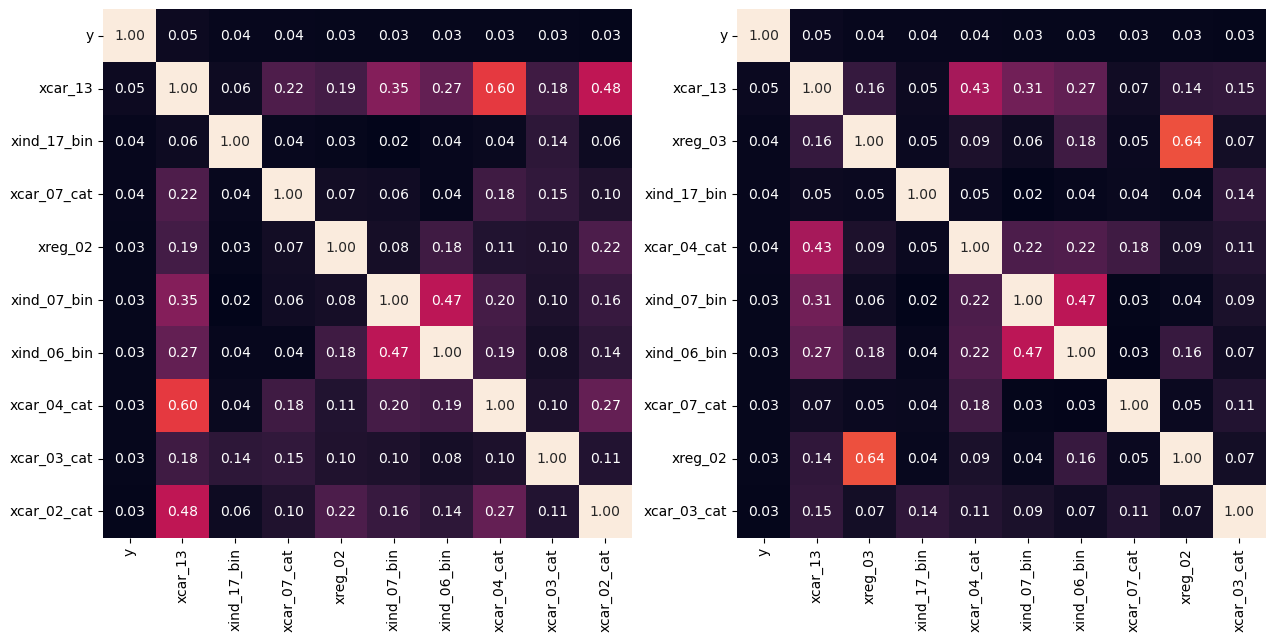

In [38]:
fig, axs = plt.subplots(ncols=2, figsize=(15,7))
sns.heatmap(corrP.abs().loc[corrP_cols,corrP_cols],ax=axs[0], cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=corrP_cols.values, xticklabels=corrP_cols.values)
sns.heatmap(corrS.abs().loc[corrS_cols,corrS_cols],ax=axs[1], cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=corrS_cols.values, xticklabels=corrS_cols.values)

# 7. Using PCA

I decided to gradually increase number of features from 3 to 30 while using PCA. And we can see f1 score increased on 1% comparing with start value. But, in general, PCA has the same effect as we used ASM before.

In [39]:
 for components in range(3, 30, 2):
    pca = PCA(n_components=components)
    X_train_copy = X_train.copy()
    X_test_copy = X_test.copy()
    X_train_copy = pca.fit_transform(X_train_copy)
    X_test_copy = pca.transform(X_test_copy)
    
    model = DecisionTreeClassifier()
    model.fit(X_train_copy, y_train)
    
    y_pred = model.predict(X_test_copy)
    accuracy_score_test = accuracy_score(y_test, y_pred)
    f1_score_test = f1_score(y_test, y_pred)
    print('Components: ', components, '\nAccuracy: ', accuracy_score_test,'\nF1-score: ', f1_score_test)

Components:  3 
Accuracy:  0.9275723898087246 
F1-score:  0.044971200708905625
Components:  5 
Accuracy:  0.9235990356425829 
F1-score:  0.04232915657576077
Components:  7 
Accuracy:  0.9232210209756139 
F1-score:  0.04473244147157191
Components:  9 
Accuracy:  0.9226918004418572 
F1-score:  0.04324773885019233
Components:  11 
Accuracy:  0.9219861730635148 
F1-score:  0.04738947584367628
Components:  13 
Accuracy:  0.9221793805599657 
F1-score:  0.04710964822053075
Components:  15 
Accuracy:  0.9208857303663383 
F1-score:  0.04521492295214924
Components:  17 
Accuracy:  0.9199784951656125 
F1-score:  0.046064490286400965
Components:  19 
Accuracy:  0.9208857303663383 
F1-score:  0.049454985870004034
Components:  21 
Accuracy:  0.9203901111363121 
F1-score:  0.05011526510975243
Components:  23 
Accuracy:  0.9198860915803533 
F1-score:  0.04772840738891663
Components:  25 
Accuracy:  0.9201381013583327 
F1-score:  0.05034462091699131
Components:  27 
Accuracy:  0.9220617759969086 
F1-sc

# 8. Find the best combination

I decided to choose ASM and different types of binning and also PCA and different types of binning because I reliased that by decreasing number of features we can achieve better accuracy. 

In [40]:
df_copy = df.copy() 

In [41]:
# Equal width binning
# Divide columns into bins with the same interval 
bins_names = [1, 2, 3, 4, 5]
for col in col_bin:
    df_copy[col] = pd.cut(df_copy[col], 5, labels=bins_names, retbins=True)[0]

In [42]:
# ASM for each column
count_asm_dict = {}
for column in df_copy.columns:
    count_asm = df_copy[column].nunique()
    count_asm_dict[column] = count_asm
    
sorted_asm_dict = dict(sorted(count_asm_dict.items(), key=lambda item: item[1], reverse=True))
columns = list(sorted_asm_dict.keys())[0:5]

In [43]:
columns

['xcar_14', 'xcar_12', 'xcar_11_cat', 'xcalc_10', 'xcalc_14']

In [44]:
X, y = df_copy.drop('y', axis=1), df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=True, random_state=42)

In [45]:
columns

['xcar_14', 'xcar_12', 'xcar_11_cat', 'xcalc_10', 'xcalc_14']

In [46]:
X_train = X_train[columns]
X_test = X_test[columns]

In [47]:
# Apply decision tree classifier to test new approach
clf = DecisionTreeClassifier()
y_pred = clf.fit(X_train, y_train).predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)

print(cnf_matrix)
accuracy_score_test = accuracy_score(y_test, y_pred)
f1_score_test = f1_score(y_test, y_pred)
print('Accuracy: ', accuracy_score_test,'\nF1-score: ', f1_score_test)

[[113606   1019]
 [  4364     54]]
Accuracy:  0.9547810455045656 
F1-score:  0.01966854853396467


In [48]:
# Calculating PCA for all 5 features we selected from ASM
pca = PCA(n_components=5)
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()
X_train_copy = pca.fit_transform(X_train_copy)
X_test_copy = pca.transform(X_test_copy)
    
model = DecisionTreeClassifier()
model.fit(X_train_copy, y_train)

y_pred = model.predict(X_test_copy)

cnf_matrix = confusion_matrix(y_test, y_pred)
print(cnf_matrix)

accuracy_score_test = accuracy_score(y_test, y_pred)
f1_score_test = f1_score(y_test, y_pred)
print('Components: ', 5, '\nAccuracy: ', accuracy_score_test,'\nF1-score: ', f1_score_test)

[[113720    905]
 [  4361     57]]
Components:  5 
Accuracy:  0.9557638836386851 
F1-score:  0.021189591078066918


Try equal depth binning with ASM and PCA

In [49]:
df_copy = df.copy()

In [50]:
X, y = df_copy.drop('y', axis=1), df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=True, random_state=42)

In [51]:
# Equal depth binning 
# Divide columns into bins with the same bins' size
col_bin = ['xreg_03', 'xcar_13']
for col in col_bin:
    df_copy[col] = pd.qcut(df_copy[col], q=4).cat.codes

In [52]:
# ASM for each column
count_asm_dict = {}
for column in df_copy.columns:
    count_asm = df_copy[column].nunique()
    count_asm_dict[column] = count_asm
    
sorted_asm_dict = dict(sorted(count_asm_dict.items(), key=lambda item: item[1], reverse=True))
columns = list(sorted_asm_dict.keys())[0:5]

In [53]:
columns

['xcar_14', 'xcar_12', 'xcar_11_cat', 'xcalc_10', 'xcalc_14']

In [54]:
X, y = df_copy.drop('y', axis=1), df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=True, random_state=42)

In [55]:
X_train = X_train[columns]
X_test = X_test[columns]

In [56]:
# Apply decision tree classifier to test new approach
clf = DecisionTreeClassifier()
y_pred = clf.fit(X_train, y_train).predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)

print(cnf_matrix)
accuracy_score_test = accuracy_score(y_test, y_pred)
f1_score_test = f1_score(y_test, y_pred)
print('Accuracy: ', accuracy_score_test,'\nF1-score: ', f1_score_test)

[[113618   1007]
 [  4362     56]]
Accuracy:  0.9548986500676226 
F1-score:  0.02043422733077906


In [57]:
# Calculating PCA for all 5 features we selected from ASM
pca = PCA(n_components=5)
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()
X_train_copy = pca.fit_transform(X_train_copy)
X_test_copy = pca.transform(X_test_copy)
    
model = DecisionTreeClassifier()
model.fit(X_train_copy, y_train)

y_pred = model.predict(X_test_copy)

cnf_matrix = confusion_matrix(y_test, y_pred)
print(cnf_matrix)

accuracy_score_test = accuracy_score(y_test, y_pred)
f1_score_test = f1_score(y_test, y_pred)
print('Components: ', 5, '\nAccuracy: ', accuracy_score_test,'\nF1-score: ', f1_score_test)

[[113733    892]
 [  4363     55]]
Components:  5 
Accuracy:  0.9558562872239443 
F1-score:  0.02050326188257223


In [58]:
# Let's try AdaBoost classifier to compare results
df_copy = df.copy()

X, y = df_copy.drop('y', axis=1), df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=True, random_state=42)

clf = AdaBoostClassifier()
y_pred = clf.fit(X_train, y_train).predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)

print(cnf_matrix)
accuracy_score_without_bin = accuracy_score(y_test, y_pred)
f1_score_without_bin = f1_score(y_test, y_pred)
print('Accuracy: ', accuracy_score_without_bin,'\nF1-score: ', f1_score_without_bin)

[[114625      0]
 [  4418      0]]
Accuracy:  0.9628873600295691 
F1-score:  0.0


We can see that all combination gives the same result. Based on observation combination of binning + ASM helps to exclude xcar_13 and xreg_03 from chosen features and it leads to better accuracy. Actual accuracy and f1 score for DecisionTree classifier are pretty much the same as for AdaBoost classifier at start. 